In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn  
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Prep

In [2]:
def get_windows(x,window_size,stride):
    max_idx = len(x[:-window_size])
    window_list = []
    for idx in np.arange(0,max_idx,step=stride):
        window_list.append(x[idx:idx+window_size])
    return window_list

def data_prep(path,window_size,stride):

    data_pd = pd.read_csv(path,index_col=0)

    data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

    sensor_cols = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','mag_x','mag_y','mag_z']

    for sens in ['acc','gy','mag']:
        cols = [sens+'_x',sens+'_y',sens+'_z']
        scaler = StandardScaler()
        scaled = scaler.fit_transform(data_pd[cols].values)
        data_pd[cols] = scaled

    data_list = data_pd.groupby(['subject_id','label','genre_coded'])[sensor_cols].agg(list).reset_index()

    for col in sensor_cols:
        data_list[col] = data_list[col].apply(lambda x: get_windows(x,window_size,stride))

    data_list = data_list.explode(sensor_cols)

    return data_list

In [3]:
class CreateDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_tensor = torch.tensor(self.data.iloc[idx,3:].tolist(),dtype=torch.float).permute(1,0)
        label = torch.tensor(self.data.iloc[idx,2],dtype=torch.long)
        return input_tensor.to(device), label.to(device)

### Model Training

In [4]:
class TransformerModel(nn.Module):

    def __init__(self):
        super(TransformerModel, self).__init__()

        self.wpe = nn.Embedding(window_size, 9)
        self.transformer_block = nn.TransformerEncoderLayer(d_model=9, nhead=1, dim_feedforward=64, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.transformer_block,1)
        self.ln = nn.LayerNorm(9)
        self.fc = nn.Sequential(nn.Linear(window_size * 9, 64),
                                nn.ReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(64, 4))

    def forward(self, x):
        
        S = x.shape[1]
        pos_embed = torch.arange(0, S, dtype=torch.long, device=x.device)
        pos_embed = self.wpe(pos_embed)
        x = x + pos_embed
        x = self.transformer(x)
        x = self.ln(x) 
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
def train(model):
    
    max_acc = -1
    
    for epoch in range(num_epoch):

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        train_loss = 0
        counter = 0

        model.train()
        for input_tensor,label in train_loader:

            optimizer.zero_grad()
            preds = model(input_tensor)
            loss = criterion(preds, label)
            train_loss += loss.item()
            counter += 1
            loss.backward()
            optimizer.step()

        train_loss = train_loss/counter
        print(f'Epoch {epoch+1} training loss: {train_loss}')

        model.eval()
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        val_loss = 0
        counter = 0
        preds_all = []
        labels_all = []
        for input_tensor,label in val_loader:
            with torch.no_grad():
                preds = model(input_tensor)
                loss = criterion(preds,label).item()
            val_loss += loss
            counter += 1
            preds_all.extend(torch.argmax(preds,dim=-1).tolist())
            labels_all.extend(label.tolist())
        val_loss = val_loss/counter
        acc = accuracy_score(labels_all,preds_all)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1} validation loss: {val_loss}, validation accuracy: {acc}')
        
        
        if acc>max_acc:
            print('saved...')
            torch.save(model,'best.model')
            max_acc = acc

In [13]:
window_size = 90
stride = 5
num_epoch = 10
val_per_genre = 2
batch_size = 256
lr = 4e-3


data_all = data_prep("data/data_trimmed_merged.csv",window_size,stride)

In [ ]:
res_list = []

for test_subject in data_all['subject_id'].unique():
    
    train_val_pd = data_all[data_all['subject_id']!=test_subject]
    test_pd = data_all[data_all['subject_id']==test_subject]
    
    idx_pd = train_val_pd.reset_index(drop=False).groupby('genre_coded')['index'].agg(list)
    val_indices = idx_pd.apply(lambda x: np.random.choice(np.unique(x),val_per_genre)).explode().tolist()
    train_pd = train_val_pd[~train_val_pd.index.isin(val_indices)]
    val_pd = train_val_pd[train_val_pd.index.isin(val_indices)]

    train_data = CreateDataset(train_pd)
    val_data = CreateDataset(val_pd)
    test_data = CreateDataset(test_pd)
    
    model = TransformerModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.3, min_lr=1e-6)

    train(model)
    
    model = torch.load('best.model')
    model.eval()
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    preds_all = []
    for input_tensor,label in test_loader:
        with torch.no_grad():
            preds = model(input_tensor)
        preds_all.extend(torch.argmax(preds,dim=-1).tolist())

    test_pd['preds'] = preds_all
    print(accuracy_score(test_pd['genre_coded'],test_pd['preds']))
    res_list.append(test_pd)

### Test

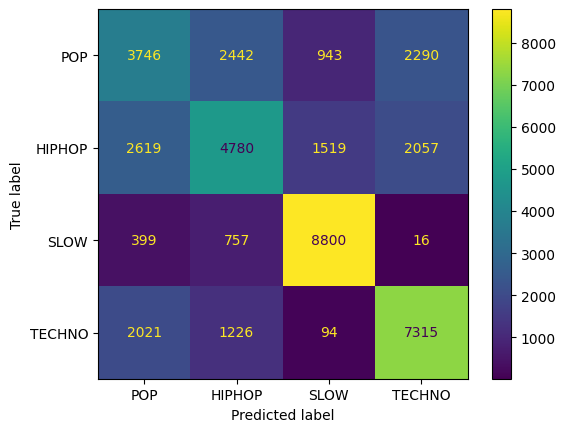

Accuracy: 0.6006484009360374
F1: 0.591978886057701


In [24]:
eval_pd = pd.concat(res_list)

conf_mat = confusion_matrix(eval_pd['genre_coded'],eval_pd['preds'])



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(eval_pd['genre_coded'],eval_pd['preds'])}")
print(f"F1: {f1_score(eval_pd['genre_coded'],eval_pd['preds'],average='weighted')}")

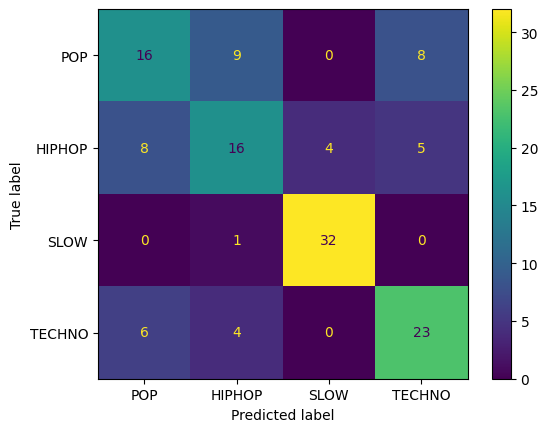

Test Accuracy: 0.6590909090909091
Test F1: 0.652518978605935


In [29]:
eval_pd = eval_pd.groupby(['subject_id','label','genre_coded'])['preds'].agg(list).reset_index()
eval_pd['pred_final'] = eval_pd['preds'].apply(lambda x: max(set(x), key = x.count))

conf_mat = confusion_matrix(eval_pd['genre_coded'],eval_pd['pred_final'])



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"Test Accuracy: {accuracy_score(eval_pd['genre_coded'],eval_pd['pred_final'])}")
print(f"Test F1: {f1_score(eval_pd['genre_coded'],eval_pd['pred_final'],average='weighted')}")